In [1]:
import string
import joblib
from os import path

import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import ls, cat
from pathlib import Path

from time import time

tqdm.pandas()

In [2]:
# #Anton
# DATA_DIR = Path('D:/data/lenta')
# OUTPUT_DIR = Path('D:/data/lenta')

# Dmitry
DATA_DIR = "../../data"
TRAIN_PATH = f'{DATA_DIR}/train_data.csv'
LEMMAS_PATH = f'{DATA_DIR}/train_lemmas_with_date.csv'
ENTITIES_PATH = f'{DATA_DIR}/train_entities_with_date.csv'

# #Anton
# TRAIN_PATH = Path('D:/data/lenta/lenta-ru-news.csv/lenta-ru-news.csv')
# NUM_ROWS = 5000

# TRAIN_LEMMAS_PATH = OUTPUT_DIR / 'train_lemmas.csv'
# TRAIN_LEMMAS_PATH_ALL = OUTPUT_DIR / 'train_lemmas_all.csv'


ls(DATA_DIR)

DIR      ../../data/stopwords-ru
  4.1 MB ../../data/consultant-news-01.01.2022-08.10.2022.csv
  2.7 MB ../../data/consultant-news_lemmas.csv
 38.3 MB ../../data/lenta-economics-01.01.2022-08.10.2022.csv
 24.1 MB ../../data/lenta-economics_lemmas.csv
  2.1 GB ../../data/lenta-ru-news.csv
 20.0  B ../../data/roles.csv
  6.7 MB ../../data/tg-channels.csv
 44.9 MB ../../data/train_data.csv
 21.4 MB ../../data/train_entities.csv
 21.7 MB ../../data/train_entities_with_date.csv
 28.3 MB ../../data/train_lemmas.csv
 28.6 MB ../../data/train_lemmas_with_date.csv
 22.7 MB ../../data/train_tokens.csv


In [10]:
# df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)
# df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)
df_train = pd.read_csv(LEMMAS_PATH, parse_dates=['date'])
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S', utc=True)

display(df_train.head(3))
display(df_train.shape)

,id,title,text,date
0,1293,вырасти пособие безработица,январь год вступить сила постановление правите...,2022-01-01 00:10:00+00:00
1,1294,вырасти,вступить сила федеральный закон внесение измен...,2022-01-01 00:12:00+00:00
2,1295,разрешить покупать лекарство онлайн,январь начаться эксперимент онлайн продаже лек...,2022-01-01 00:23:00+00:00


(15968, 4)

## Features

In [11]:
text_cols = ['title', 'text']
all_colls = ['title', 'text', 'date']
text_cols, all_colls

(['title', 'text'], ['title', 'text', 'date'])

In [12]:
df_train[all_colls].head()

,title,text,date
0,вырасти пособие безработица,январь год вступить сила постановление правите...,2022-01-01 00:10:00+00:00
1,вырасти,вступить сила федеральный закон внесение измен...,2022-01-01 00:12:00+00:00
2,разрешить покупать лекарство онлайн,январь начаться эксперимент онлайн продаже лек...,2022-01-01 00:23:00+00:00
3,частично отменить главный налог,январь уплата налог добавить стоимость освобод...,2022-01-01 00:27:00+00:00
4,вырасти цена табак,январь минимальный цена табачный продукция дос...,2022-01-01 00:38:00+00:00


In [13]:
df_train[df_train['date'].isna()]

,id,title,text,date


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 1000

data_samples = df_train.title.fillna('')
data_samples

0                              вырасти пособие безработица
1                                                  вырасти
2                      разрешить покупать лекарство онлайн
3                          частично отменить главный налог
4                                       вырасти цена табак
                               ...                        
15963             формат заказ заявка перевозка автомобиль
15964    подтвердить задолженность мера законный решить...
15965      выплата работник учреждение признать оформление
15966             требование электронный кадровый документ
15967        часть бизнес освободить плановый проверка год
Name: title, Length: 15968, dtype: object

In [15]:

# Use tf-idf features for NMF.
print("Extracting tf-idf features")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features
done in 0.119s.
Extracting tf features for
done in 0.065s.



In [16]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 25.760s.


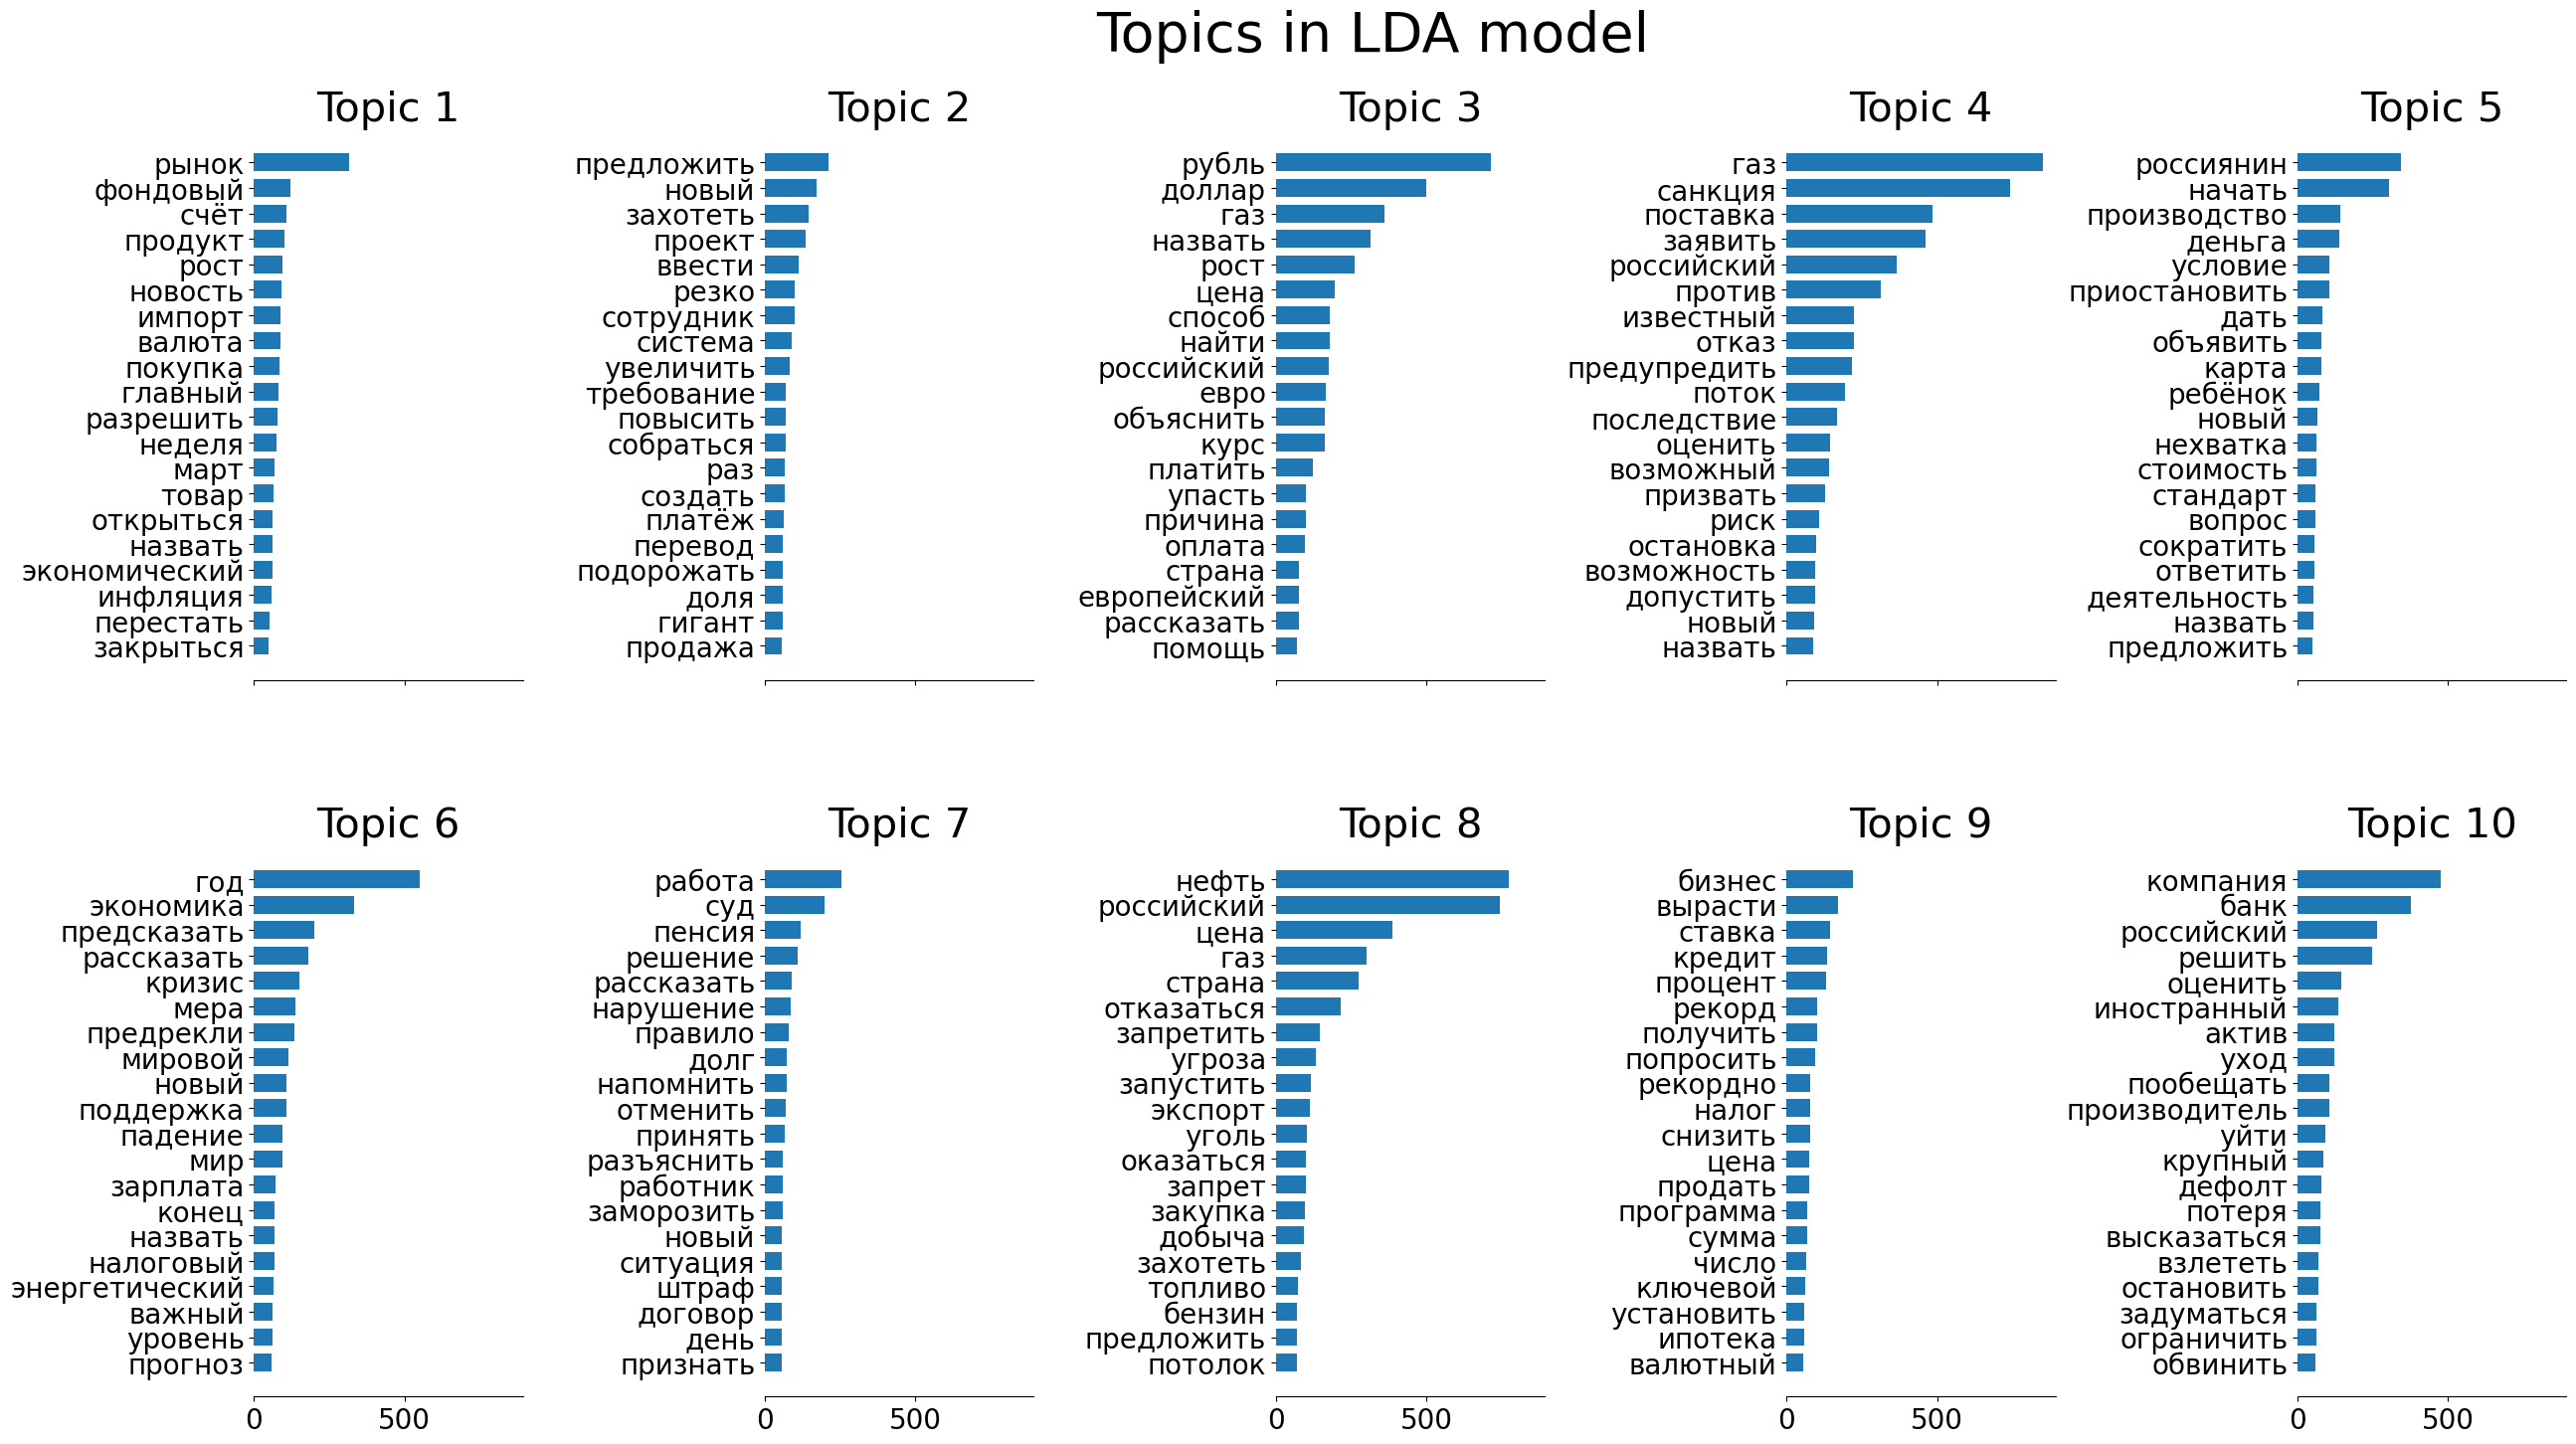

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)

t0 = time()
doc_topics = lda.fit_transform(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [57]:
topics_treshold = 0.3

df = df_train
df['topic'] = pd.DataFrame(doc_topics).apply(list, axis=1) \
    .apply(lambda x: [i for i, w in enumerate(x) if w > topics_treshold])

df

,id,title,text,date,topic
0,1293,вырасти пособие безработица,январь год вступить сила постановление правите...,2022-01-01 00:10:00+00:00,[4]
1,1294,вырасти,вступить сила федеральный закон внесение измен...,2022-01-01 00:12:00+00:00,[8]
2,1295,разрешить покупать лекарство онлайн,январь начаться эксперимент онлайн продаже лек...,2022-01-01 00:23:00+00:00,[0]
3,1296,частично отменить главный налог,январь уплата налог добавить стоимость освобод...,2022-01-01 00:27:00+00:00,[6]
4,1297,вырасти цена табак,январь минимальный цена табачный продукция дос...,2022-01-01 00:38:00+00:00,[8]
...,...,...,...,...,...
15963,17256,формат заказ заявка перевозка автомобиль,выставить общественный обсуждение проект форма...,2022-10-30 00:00:00+00:00,[7]
15964,17257,подтвердить задолженность мера законный решить...,итог выездной проверка инспекция применить мер...,2022-10-30 00:00:00+00:00,[6]
15965,17258,выплата работник учреждение признать оформление,образовательный учреждение подать учредитель з...,2022-10-30 00:00:00+00:00,[6]
15966,17259,требование электронный кадровый документ,март год действовать единый требование состав ...,2022-10-30 00:00:00+00:00,[6]


In [58]:
df['topic'].value_counts()

[]        1942
[3]       1807
[2]       1319
[7]       1245
[5]       1075
[6]       1005
[1]        950
[9]        910
[4]        785
[0]        755
[8]        741
[3, 7]     169
[3, 9]     142
[2, 3]     129
[2, 5]     126
[3, 5]     122
[2, 7]     119
[1, 6]     112
[2, 9]     110
[6, 9]     100
[1, 8]      93
[5, 7]      90
[5, 6]      90
[1, 7]      81
[1, 9]      73
[0, 5]      73
[1, 5]      72
[2, 8]      72
[3, 4]      72
[4, 6]      71
[1, 4]      71
[1, 2]      71
[1, 3]      68
[6, 7]      67
[3, 6]      66
[4, 8]      65
[4, 9]      65
[6, 8]      64
[7, 9]      64
[2, 6]      64
[7, 8]      62
[5, 8]      59
[3, 8]      58
[5, 9]      57
[4, 7]      57
[4, 5]      57
[2, 4]      57
[0, 7]      54
[8, 9]      52
[0, 6]      52
[0, 1]      51
[0, 3]      51
[0, 9]      50
[0, 2]      49
[0, 4]      45
[0, 8]      42
Name: topic, dtype: int64

In [61]:
# смотрим новости с тематикой t
t = 1
df[df['topic'].apply(lambda x: t in x)]

,id,title,text,date,topic
8,1301,интернет гиганты приземлить,январь год иностранный интернет гиганты суточн...,2022-01-01 01:00:00+00:00,[1]
40,1333,подорожание алкоголь повышение акциз,подорожание алкоголь повышение акциз процент о...,2022-01-03 00:41:00+00:00,[1]
55,1348,увеличить импорт мороженое раз,ключевой потребитель московский мороженое итог...,2022-01-03 14:48:00+00:00,[1]
61,1354,избрать новый,аль стать новый генеральный секретарь страна э...,2022-01-04 04:08:00+00:00,[1]
64,1357,резко разбогатеть доллар,предприниматель основатель разбогатеть доллар ...,2022-01-04 05:43:00+00:00,"[1, 2]"
...,...,...,...,...,...
15913,17206,начать оформлять кредитный каникулы мобилизова...,октябрь начать оформлять кредитный каникулы мо...,2022-10-07 12:03:00+00:00,[1]
15924,17217,приготовиться падение прибыть,крупный мировой производитель смартфон готовит...,2022-10-07 14:29:00+00:00,"[1, 5]"
15943,17236,подписать указ создание новый оператор проект,подписать указ создание новый оператор проект ...,2022-10-07 21:31:00+00:00,[1]
15958,17251,хотеть продлить эксперимент упрощённый лицензи...,сентябрь год предлагать продолжить эксперимент...,2022-10-30 00:00:00+00:00,[1]


<AxesSubplot:>

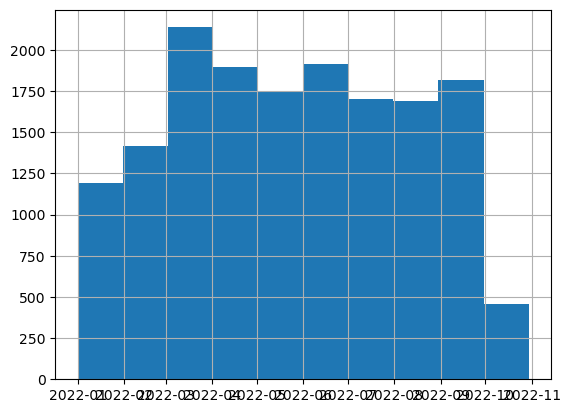

In [62]:
df_train.date.dt.date.hist()

Рапределение дат в исходном dataset


<AxesSubplot:xlabel='date,date'>

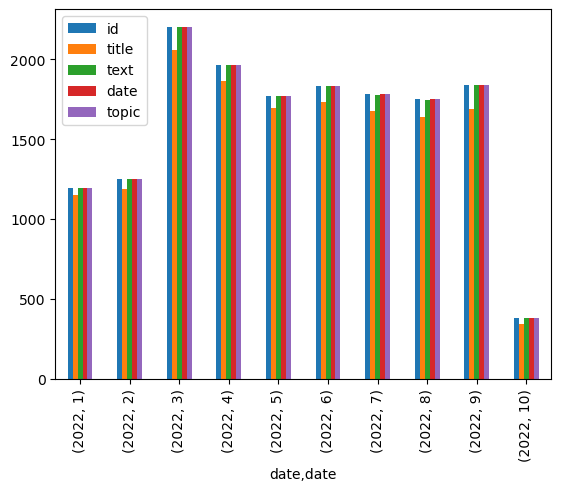

In [63]:
print('Рапределение дат в исходном dataset')
df_train.groupby([df_train["date"].dt.year, df_train["date"].dt.month]).count().plot(kind="bar")

In [64]:
print('Количество строк с датой в 1914 году:')
print(df_train[df_train.date < '1950-01-01'].date.count())

Количество строк с датой в 1914 году:
0


In [69]:
from pydoc_data.topics import topics

df_topic0 = df[df['topic'].apply(lambda x: 0 in x)].groupby(by=df['date'].dt.day).count()

In [70]:
df_topic0

,id,title,text,date,topic
date,,,,,
1,48,48,48,48,48
2,30,30,30,30,30
3,33,33,33,33,33
4,32,32,32,32,32
5,34,34,34,34,34
6,21,21,21,21,21
7,35,35,35,35,35
8,31,31,31,31,31
9,20,20,20,20,20


<AxesSubplot:title={'center':'topic 0'}, xlabel='date'>

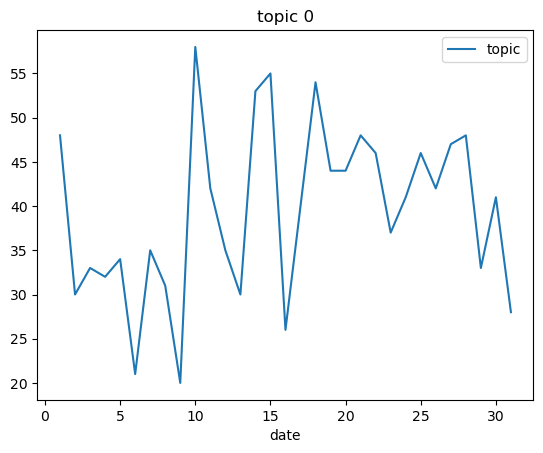

In [71]:
df_topic0.plot(y='topic',title='topic 0')

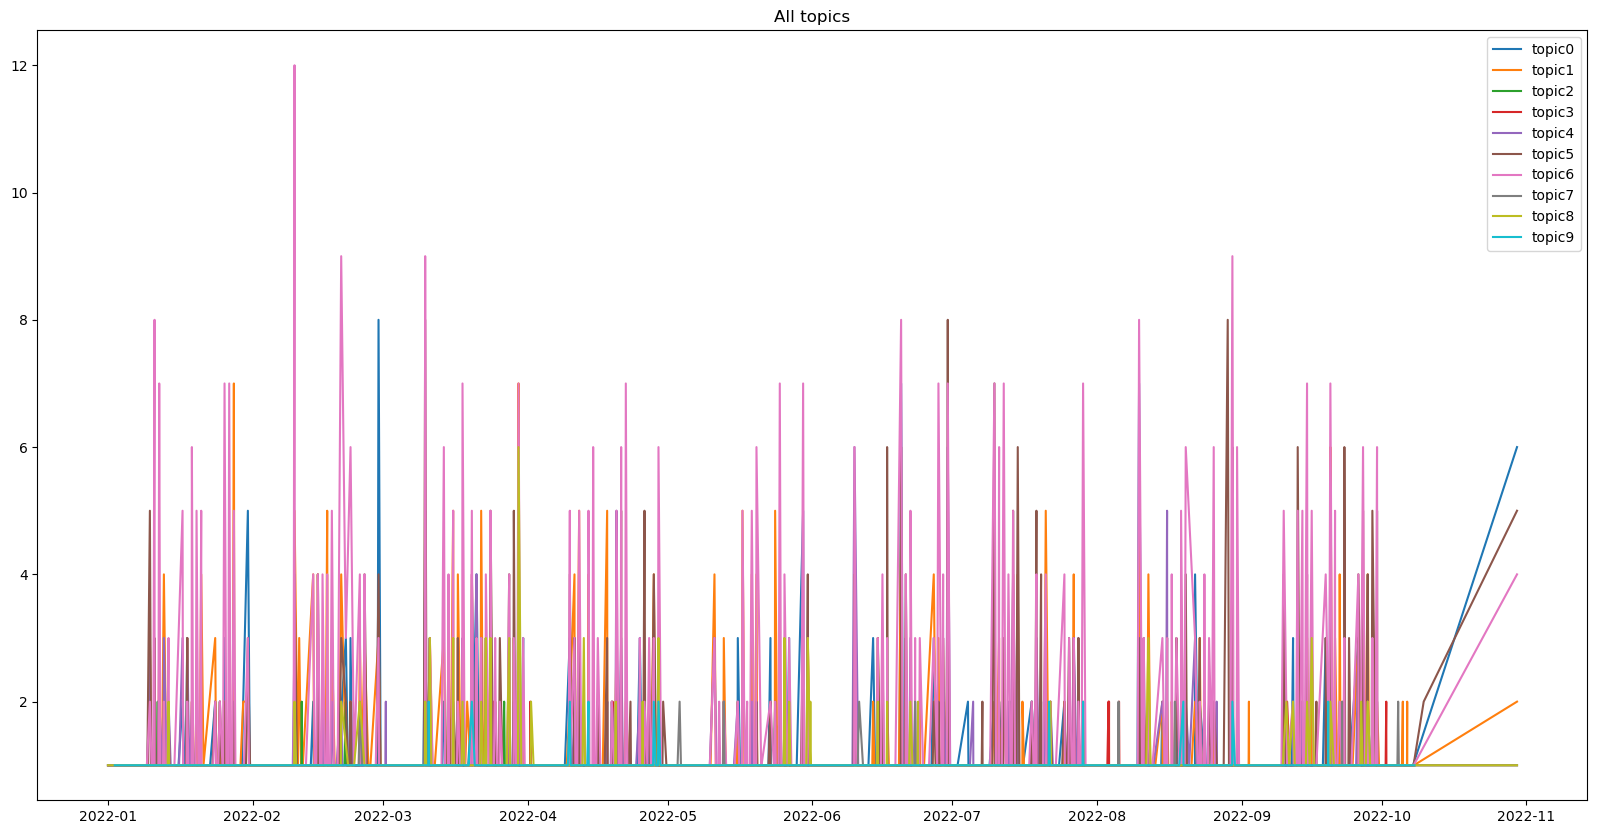

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(0, n_components):
    mask = df['topic'].apply(lambda x: i in x)
    x = df[mask].groupby(by='date').count().index.to_numpy()
    y = df[mask].groupby(by='date').count().topic.to_numpy()
    plt.plot(x, y, label = 'topic' + str(i))


plt.legend()
plt.title('All topics')
plt.show()

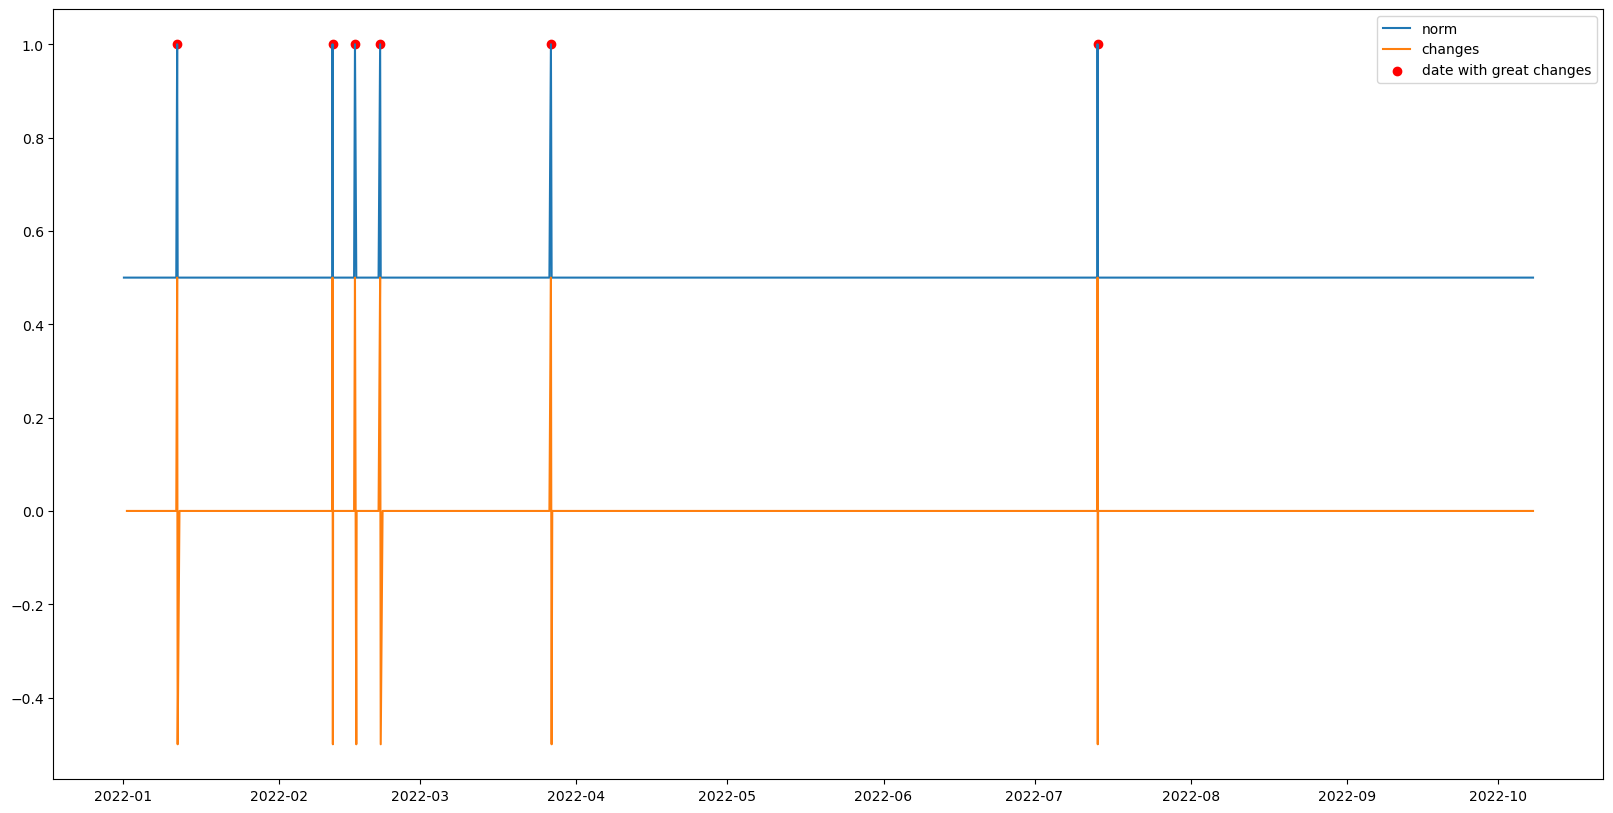

In [73]:
topic_num = 2
mask = df['topic'].apply(lambda x: topic_num in x)
date_list = df[mask].groupby(by='date').count().index.to_numpy()
count_list = df[mask].groupby(by='date').count().topic.to_numpy()

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
# ax = plt.gca()

def plot_changes_(ax, date_list, count_list, thresh=.4):

    thresh = 0.4
    topic_num = 0
    # date_list[:10], count_list[:120]

    norm_count = [float(i) / max(count_list) for i in count_list]
    ax.plot(date_list, norm_count, label='norm')

    changes = []
    for i in range(1, len(norm_count)):
        changes.append(norm_count[i] - norm_count[i-1])
        
    ax.plot(date_list[1:], changes, label='changes')
    ind_great_changes = [i+1 for i,v in enumerate(changes) if v >thresh]
    ax.scatter(np.array(date_list)[ind_great_changes], np.array(norm_count)[ind_great_changes], c='r', label='date with great changes')

    # ax.title('Даты с изменением в процентных изменения максимума более чем на {}%'.format(thresh *100))
    ax.legend()
    
    
plot_changes_(ax, date_list, count_list)

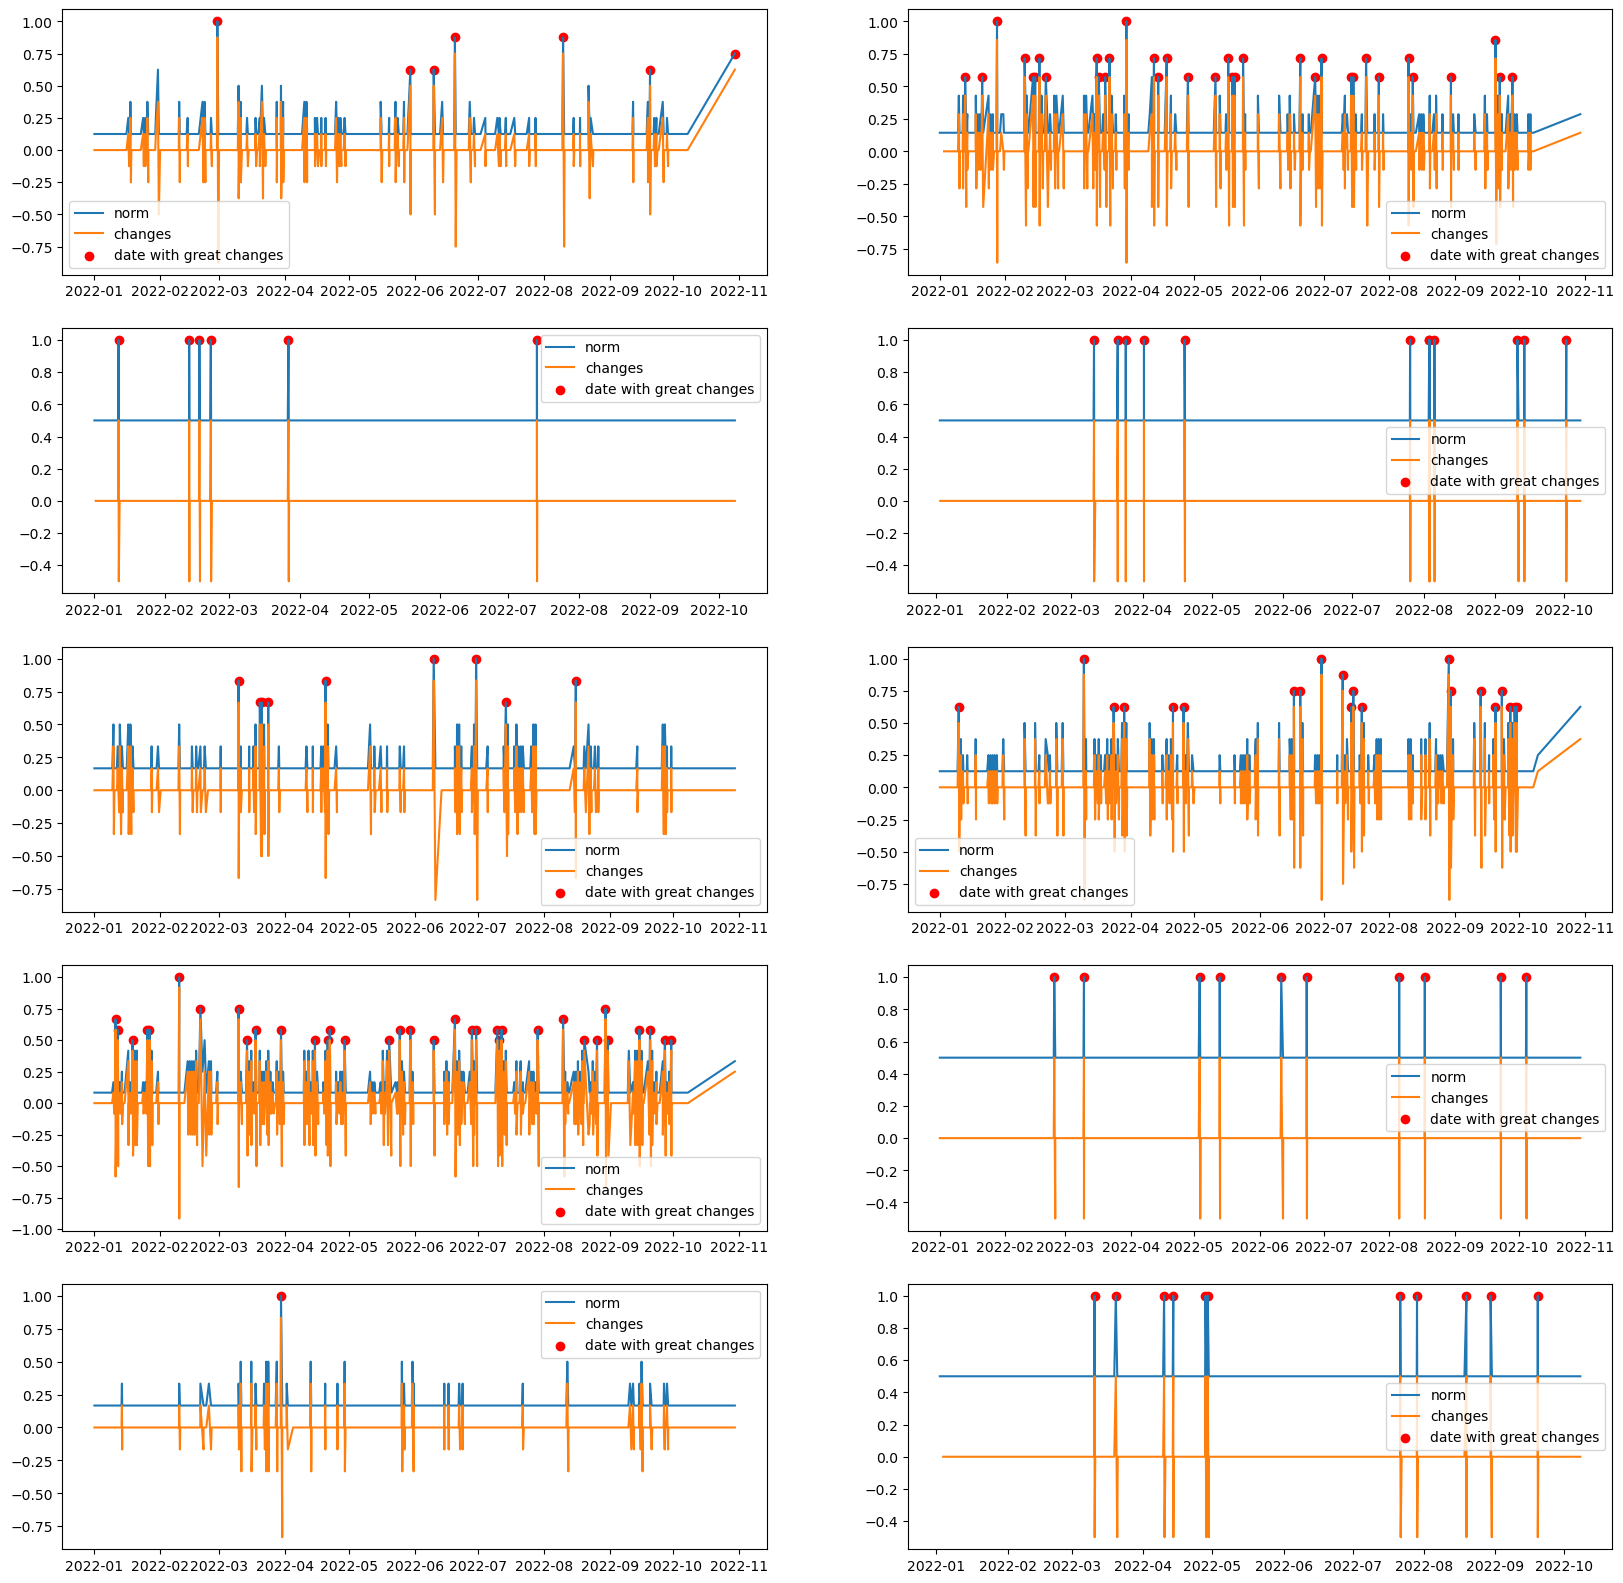

In [74]:
fig, axes = plt.subplots(5, 2)

fig.set_size_inches(20, 20)

ax = axes.flatten()

for i in range(0, 10):
    topic_num = i
    mask = df['topic'].apply(lambda x: topic_num in x)

    date_list = df[mask].groupby(by='date').count().index.to_numpy()
    count_list = df[mask].groupby(by='date').count().topic.to_numpy()
    plot_changes_(ax[i], date_list, count_list)

In [75]:
topic_num = 0
thresh = 0.4

mask = df['topic'].apply(lambda x: topic_num in x)
date_list = df[mask].groupby(by='date').count().index.to_numpy()
count_list = df[mask].groupby(by='date').count().topic.to_numpy()
norm_count = [float(i) / max(count_list) for i in count_list]
changes = []

for i in range(1, len(norm_count)):
    changes.append(norm_count[i] - norm_count[i-1])

ind_great_changes = [i+1 for i,v in enumerate(changes) if v >thresh]

date_great_changes = np.array(date_list)[ind_great_changes]
for date in date_great_changes:
    print(date)
    ind = df[(df.date == date) & (mask)].index
    print(df_train.loc[ind].title)

2022-02-28 00:00:00+00:00
2353                      новость специалист кадр февраль
2356    основной изменение ждать специалист организаци...
2357    важный новость организация бюджетный сфера фев...
2358                            новость бухгалтер февраль
2359                         важный новость юрист февраль
2362                          март возобновить регулярный
2366        интересный новость специалист закупка февраль
2368             рабочий неделя день отдых трудиться март
Name: title, dtype: object
2022-05-30 00:00:00+00:00
8229    июнь вырасти прожиточный минимум страховой пен...
8232                          новость специалист кадр май
8235            интересный новость специалист закупка май
8238                                новость бухгалтер май
8239                             важный новость юрист май
Name: title, dtype: object
2022-06-10 00:00:00+00:00
8872                 обязанный продавать валютный выручка
8882                         суд утвердить обзор практик